# LIMPIEZA Y ANÁLISIS EXPLORATORIO
---

## Conjunto de datos para clasificación

### Integrantes
- `Garibay Zepeda, Julio Andrés` (`julio.garibay@iteso.mx`)
- `Crespo Neri, Diego Ubaldo` (`ubaldo.crespo@iteso.mx`)
- `Vázquez Sandoval, Isaac Ernesto` (`isaac.vazqsand@gmail.com`)

---

### Bibliotecas

In [16]:
# Básicas
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from IPython.display import display
from matplotlib import pyplot as plt

# Enfocadas a imágenes
import cv2
from skimage import io

In [63]:
# Swag
plt.style.use("/home/toutl/code/.toutl.mplstyle")

---

### **Visualización, exploración, preparación y análisis de datos:**

#### 1. Estructura y Metadata

In [3]:
# Creamos un objeto que nos permite acceder a todas las imágenes.
collection = io.imread_collection("../data/classification/images_gz2/*.jpg")

In [4]:
# La cantidad de imágenes disponibles
display(len(collection))

71648

In [5]:
# Asegurarnos que las imágenes tengas dimensiones iguales
all_shapes = np.stack([img.shape for img in collection])
display(all_shapes.mean(axis=0))

array([424., 424.,   3.])

Se cuentan con 71,648 imágenes en la colección.
- Formato: `.jpg`.
- Diménsiones: 424 x 424 pixeles.
- Número de bandas: 3 (RGB).
- Profundidad de color: 8 bits (valores entre 0 y 255).

##### Ejemplos

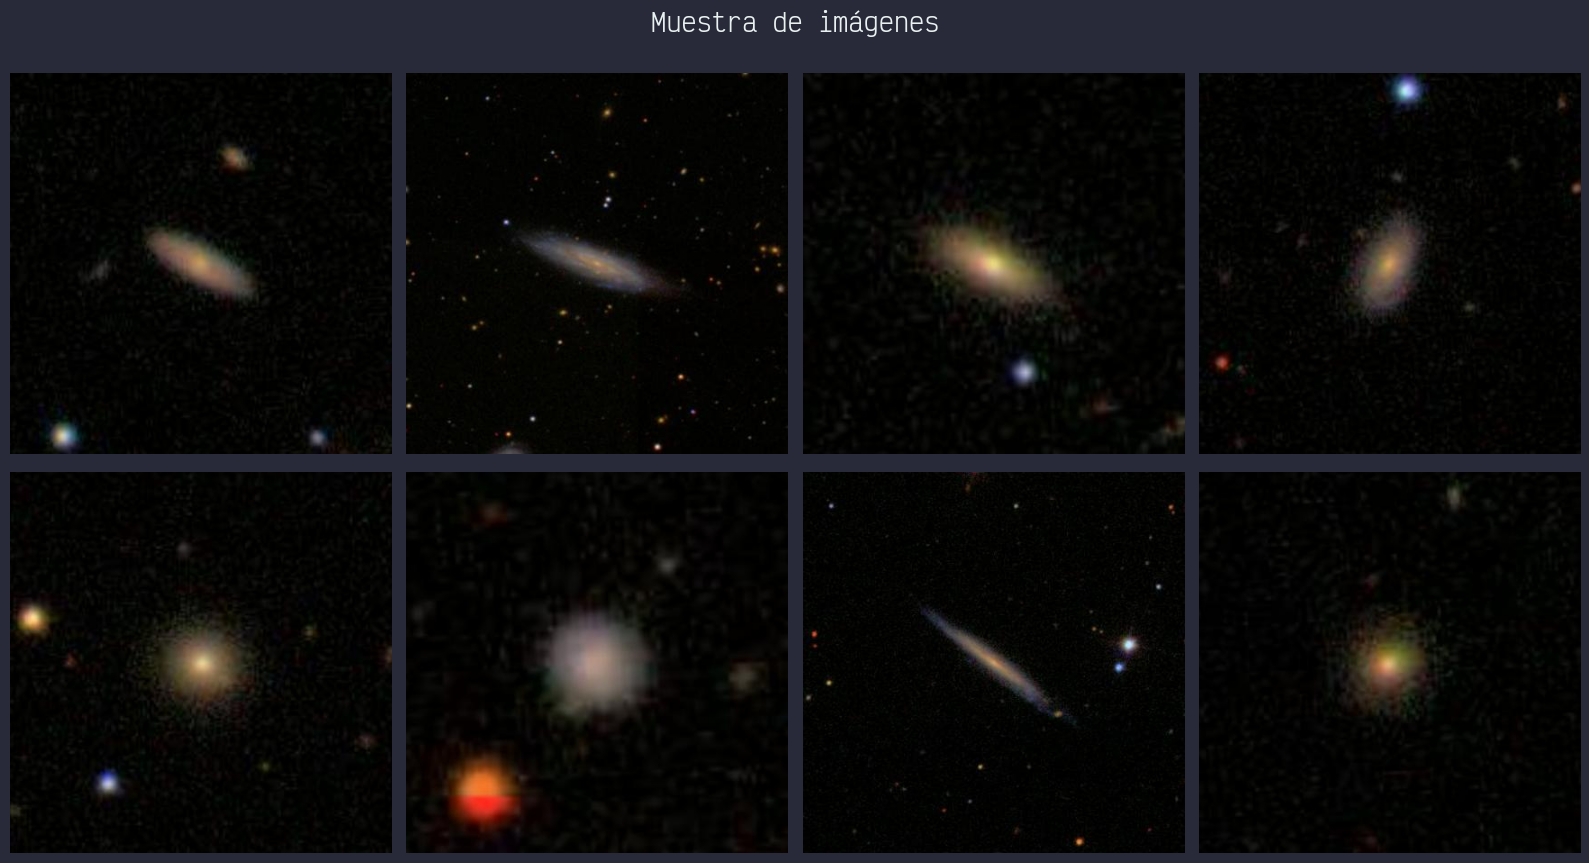

In [6]:
# Algunas imágenes del conjnto de datos
fig, axes = plt.subplots(2, 4, figsize=(16, 9), tight_layout=True)
# fig.subplots_adjust(hspace=1.55)

for i, ax in enumerate(axes.flat):
    ax.imshow(collection[i + 14])
    ax.axis("off")

fig.suptitle("Muestra de imágenes", fontsize=20)
plt.show()

Observaciones:
- En todas las imágenes se notan objetos cósmicos centrados.
- Se espera que aquellos centrados sean galaxias.
- Alrededor de los centrales se observan otros objetos, con distintos tamaños y colores.
- Algunas imágenes presentan más zoom que otras, por lo que están más pixeleadas.

Todo esto podría interferir con la identificación, o ser beneficioso.

---

#### 2. Información estadística

##### Imágenes

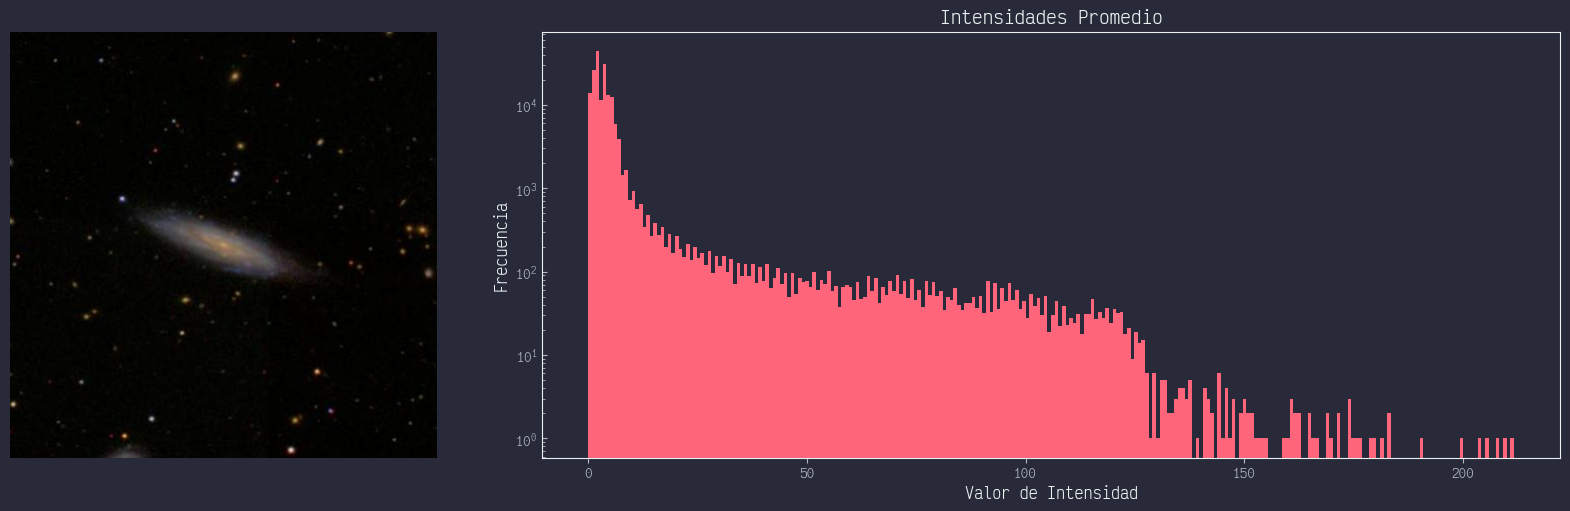

In [7]:
Galaxia = collection[15]

fig, axes = plt.subplots(
    1, 2, figsize=(16, 5), gridspec_kw={"width_ratios": [1, 2]}, constrained_layout=True
)

axes[0].imshow(Galaxia)
axes[0].axis("off")

vals = Galaxia.mean(axis=2).flatten()
axes[1].hist(vals, bins=256, log=True)
axes[1].set_title("Intensidades Promedio", fontsize=14)
axes[1].set_xlabel("Valor de Intensidad")
axes[1].set_ylabel("Frecuencia")

plt.show()

El histograma de intesidades promedio nos da una idea que la gran mayoría de los colores que aparecen en las imágenes son muy oscuros, hay muchos en tonos medios y muy pocas muy brillantes.

In [8]:
n = 0
mean = 0
M2 = 0
for img in collection:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    data = gray.astype(np.float32).ravel()
    n_i = len(data)
    mean_i = data.mean()
    var_i = data.var()

    # Actualización incremental (Welford’s algorithm)
    delta = mean_i - mean
    total_n = n + n_i
    mean += delta * n_i / total_n
    M2 += var_i * n_i + delta**2 * n * n_i / total_n
    n = total_n

std = np.sqrt(M2 / n)
print("Global mean intensity:", mean)
print("Global std intensity:", std)

Global mean intensity: 9.578544
Global std intensity: 18.399975


Con una intensidad media de 9.58 y una desviación estándar de 18.4 nos queda más que claro que los valores son muy oscuros en general.

Debido a la naturaleza de la imágenes no contamos con datos nulos, distribuciones ni datos sesgados.

##### Etiquetas

La información que ofrece el proyecto Zoo Galaxy es mucha y muy diversa.

In [9]:
# Tabla de etiquetas
df_tags = pd.read_csv("../data/classification/gz2_hart16.csv")
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239695 entries, 0 to 239694
Columns: 231 entries, dr7objid to t11_arms_number_a37_cant_tell_flag
dtypes: float64(150), int64(77), object(4)
memory usage: 422.4+ MB


Nosotros nos utilizaremos las clases que fueron clasificadas por la comunidad.

El resumen está representado por la variable `gz2_class`. 

In [10]:
all_tags = df_tags["gz2_class"].unique()
print(len(all_tags))
print("Ejemplos:", all_tags[:10])

818
Ejemplos: ['Sc+t' 'Sb+t' 'Ei' 'Er' 'Sb?t' 'Sb1m(i)' 'Sb2t' 'SBb2m' 'SBc3m' 'Sc2t']


Se reconocen muchas clasificaciónes, específicadas en [Galaxy Zoo trees](https://data.galaxyzoo.org/gz_trees/gz_trees.html), un diagrama en el que se basa la clasificación realizada en el proyecto.

Para este proyecto, se utilizarán las clasificaciones más generales:
- `Smooth`
- `Features or disks`
- `Star or artifact` (not galaxies)

In [11]:
# Obtenemos las clasificaciones básicas
types = defaultdict(lambda: [0, []])

for tag in all_tags:
    start_char = tag[0]
    types[start_char][0] += 1  # type: ignore
    types[start_char][1].append(tag)  # type: ignore

print(list(dict(types).keys()))
print([value[0] for value in dict(types).values()])

['S', 'E', 'A']
[793, 24, 1]


Se puede notar que los datos están complentamente imbalanceados en la variable de salida, algo que habrá que considerar al momento de seleccionar las métricas del modelo.

*PD: La variable* `dr7objid` *es utilizada como id para relacionar a las imágenes*

---

#### 3. Limpieza de imágenes (ejemplo)

In [12]:
import os
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import closing, footprint_rectangle
from skimage.segmentation import clear_border

Para la limpieza utilizamos arreglos de paths por eficiencia en la lectura.

In [14]:
def cargar_img(dir_imgs):
    """
    dir_imgs : directorio donde esten las imagenes
    imgages_path : path especifico de cada imagen en un array de numpy
    """
    images_path = os.listdir(dir_imgs)
    images_path = np.array(images_path)

    data = []
    for image in range(len(images_path)):
        data.append(io.imread(dir_imgs + images_path[image]))

    return np.array(data)

Aplicamos una máscara para mantener únicamente los objetos cósmicos.

In [18]:
def applied_mask(data):
    """
    data : array de las imagenes de las galaxias
    binary : regresa los binarios donde este la mayor
    """
    binary = []

    for image in data:
        gray_img = rgb2gray(image)
        thresh = threshold_otsu(gray_img)
        mask = gray_img > (thresh * 0.99)

        applied_mask = np.zeros_like(image)

        for i in range(3):
            band = image[:, :, i]
            applied_mask[:, :, i] = mask * band

        binary.append(applied_mask)

    return binary

Como todas las imágnes están centradas mantenemos el objeto obtenido en la máscara al centro.

De esta manera obtenemos la mejor calidad disponible de el objeto de interés.

In [38]:
def crop_galaxy(data, factor=1.5):
    """
    Recorta la galaxia centrada en una imagen RGB usando umbral adaptativo.
    img : ndarray
        Imagen RGB o en escala de grises con la galaxia centrada.
        Multiplicador del tamaño de la galaxia para dejar margen (1.5 por defecto).

    recorte : ndarray
        Subimagen recortada alrededor de la galaxia.
    """
    # Convertir a escala de grises si es RGB

    croped = []

    for img in data:
        if img.ndim == 3:
            gray = rgb2gray(img)
        else:
            gray = img
        thresh = threshold_otsu(gray)
        binary = gray > thresh

        label_img = label(binary)

        if label_img.max() == 0:  # type: ignore

            return img

        largest = max(regionprops(label_img), key=lambda r: r.area)
        minr, minc, maxr, maxc = largest.bbox

        cy, cx = (minr + maxr) // 2, (minc + maxc) // 2
        size = int(max(maxr - minr, maxc - minc) * factor)

        half = size // 2
        starty, endy = max(cy - half, 0), min(cy + half, img.shape[0])
        startx, endx = max(cx - half, 0), min(cx + half, img.shape[1])

        recorte = img[starty:endy, startx:endx]

        croped.append(recorte)

    return croped

Al tener muchas imágenes lo probamos con una pequeña cantidad

In [40]:
path = "../data/classification/small/"
data = cargar_img(path)
binary = applied_mask(data)  # mascara aplicada
croped = crop_galaxy(data)

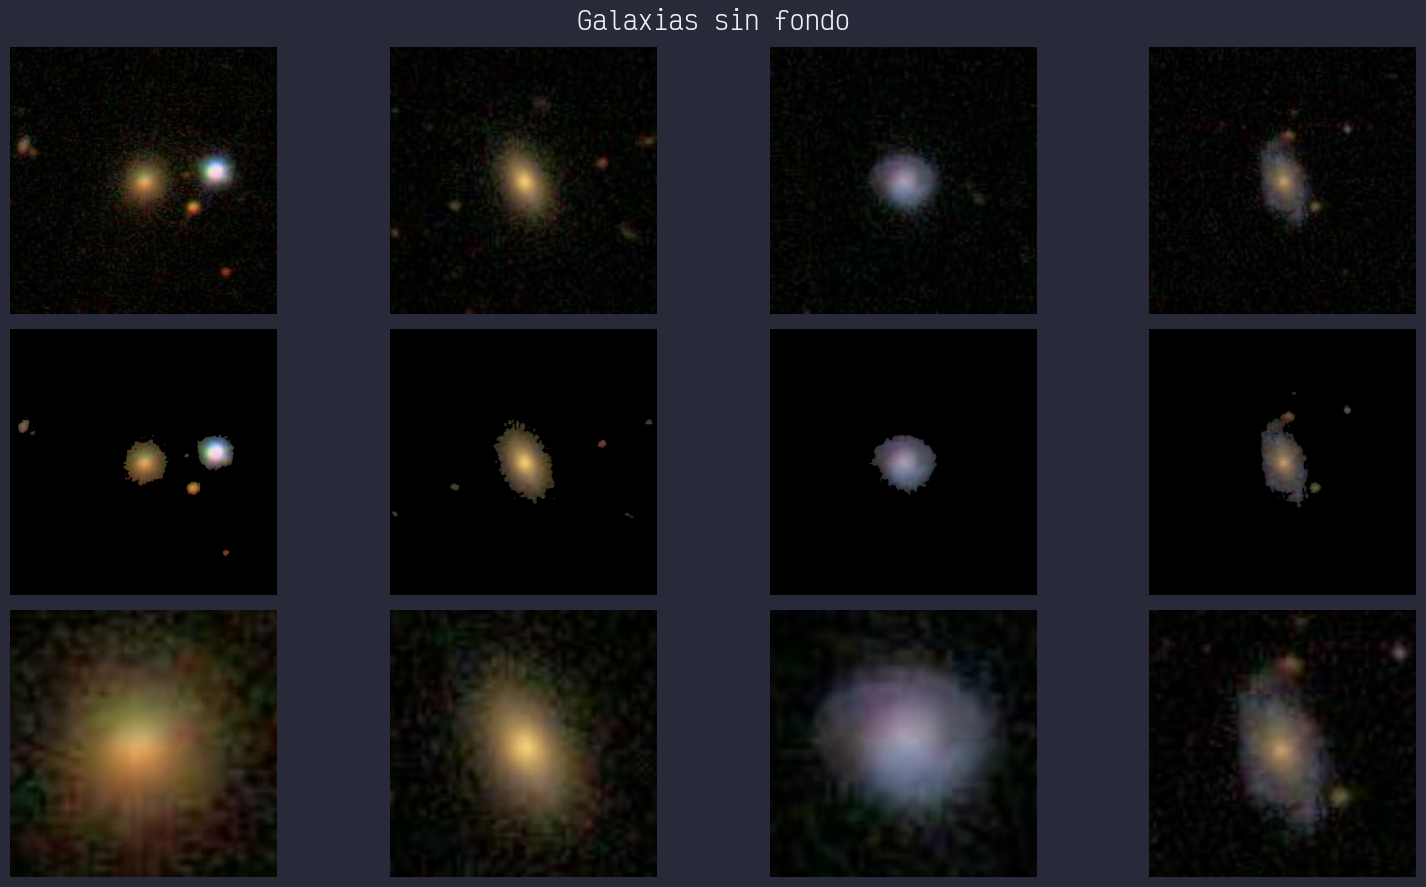

In [62]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9), tight_layout=True)

n = 11

for i in range(4):
    axes[0, i].imshow(data[i + n])
    axes[0, i].axis("off")
    axes[1, i].imshow(binary[i + n])
    axes[1, i].axis("off")
    axes[2, i].imshow(croped[i + n])
    axes[2, i].axis("off")

fig.suptitle("Galaxias sin fondo", fontsize=20)
plt.show()

Como se puede observar, en cada paso se está manteniendo solo el objeto central.

Hasta que nuestra imagen sea casi por completo la galaxia.

---

#### 4. Conclusiones

Para poder lograr construir un buen modelo de clasificación de imágenes de galaxias, tendremos en cuenta lo siguiente:
- Hay que encapsular los objetos de interés para evitar que el el modelo utilizado se sobreajuste al ruido o tenga sesgo por la aparición de otros objetos en sus vecinidades.
    - También para que haya una mayor importancia de la intensidad de la galaxia, en lugar del fondo
- Las imagenes astronómicas requieren de un tratamiento especial, diferente a las imágenes comunes. No todos los filtros funcionan con estas.
- Tenemos que prestar atención en cómo representa el modelo la proporción de categorías en la variable objetivo.

Modelo a aplicar:

En base a lo observado y al estado del arte en análisis de imágenes, lo más conveniente podría ser una Red Neuronal Convolucional. Ya que...
- Son robustas frente a datos complejos.
    - Patrones raros.
- No necesitamos interpretabilidad en el modelo.
- Generalizan bien, en lugar de elegir pixel por pixel aprenden estructuras generales.

También podríamos probar una máquina de soporte vectorial con PCA, para probar un modelo más ligero.
- Sin embargo, habría que hacer otras transformaciones para poderlos utilizar bien.

---

#### 5. Datos

Links de descarga:

[Images (Zenodo)](https://zenodo.org/records/3565489/files/images_gz2.zip?download=1)

[Classification Table (GalaxyZoo)](https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz)